In [263]:
import numpy as np
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
data_files = {
        "abdellah": {
        "jumping": {
            "backright": "data/jumping/ajbrp_data.csv",
            "frontleft": "data/jumping/ajflp_data.csv",
        },
        "walking": {
            "backright": "data/walking/awbrp_data.csv",
            "frontleft": "data/walking/awflp_data.csv",
        },
    },
    }

In [323]:
activity_codes = {"jumping": 0, "walking": 1}

def load_and_label_data(data_files):
    labeled_data = []
    for person, activities in data_files.items():
        for activity, positions in activities.items():
            for position, file_path in positions.items():
                data = pd.read_csv(file_path)
                data["Activity"] = activity_codes[activity]
                labeled_data.append(data)
    return labeled_data

# Preprocessing and feature extraction functions
def remove_five_seconds_rolling(df, window_size):
    start_time = df["Time (s)"].min()
    end_time = df["Time (s)"].max()
    df = df[(df["Time (s)"] > start_time + 5) & (df["Time (s)"] < end_time - 5)]

    df = df.rolling(window_size).mean()
    df = df.dropna()
    return df

def segment_data(data, window_size=5, sample_rate=100):
    samples = len(data)
    window_samples = window_size * sample_rate
    segments = []
    for i in range(0, samples, window_samples):
        segment = data[i:i+window_samples]
        if len(segment) == window_samples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments

def extract_features(data):
    # mean
    mean = data.mean(axis=1)
    # std
    std = data.std(axis=1)
    # max
    max = data.max(axis=1)
    # min
    min = data.min(axis=1)
    # median
    median = np.median(data, axis=1)
    # range
    range = max - min
    # variance
    variance = np.var(data, axis=1)
    # rms
    rms = np.sqrt(np.mean(data**2, axis=1))
    # skew
    skew = pd.DataFrame(data).skew(axis=1)
    # kurtosis
    kurtosis = pd.DataFrame(data).kurtosis(axis=1)
    # combine all features into a feature vector
    features = np.column_stack(mean, std, max, min, median, range, variance, rms, skew, kurtosis)
    
    return features

In [342]:
labeled_data = load_and_label_data(data_files)
preprocessed_data = [remove_five_seconds_rolling(df, 50) for df in labeled_data]

segmented_data = []
for data in preprocessed_data:
    segmented_data.extend(segment_data(data))
print(len(segmented_data))
segmented_data[0].head(20)

62


,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
2547,25.340866,0.881942,0.058335,0.747935,17.476212,0.0
2548,25.350907,0.855565,0.128337,0.799068,17.532410,0.0
2549,25.360947,0.815957,0.168182,0.802188,17.587747,0.0
2550,25.370988,0.749906,0.198069,0.810680,17.642396,0.0
2551,25.381029,0.648341,0.239855,0.864142,17.729127,0.0
2552,25.391069,0.556247,0.293640,0.865786,17.796565,0.0
2553,25.401110,0.497729,0.342510,0.826346,17.843490,0.0
2554,25.411151,0.493226,0.364181,0.757006,17.857709,0.0
2555,25.421192,0.533313,0.342639,0.673959,17.831416,0.0
2556,25.431232,0.598583,0.288849,0.589876,17.777544,0.0


In [270]:
# Extract features and labels
feature_matrix = []
label_vector = []

for segment in segmented_data:
    features = extract_features(segment)
    label = segment.iloc[0, -1]
    feature_matrix.append(features)
    label_vector.append(label)

feature_matrix = np.array(feature_matrix)
label_vector = np.array(label_vector)

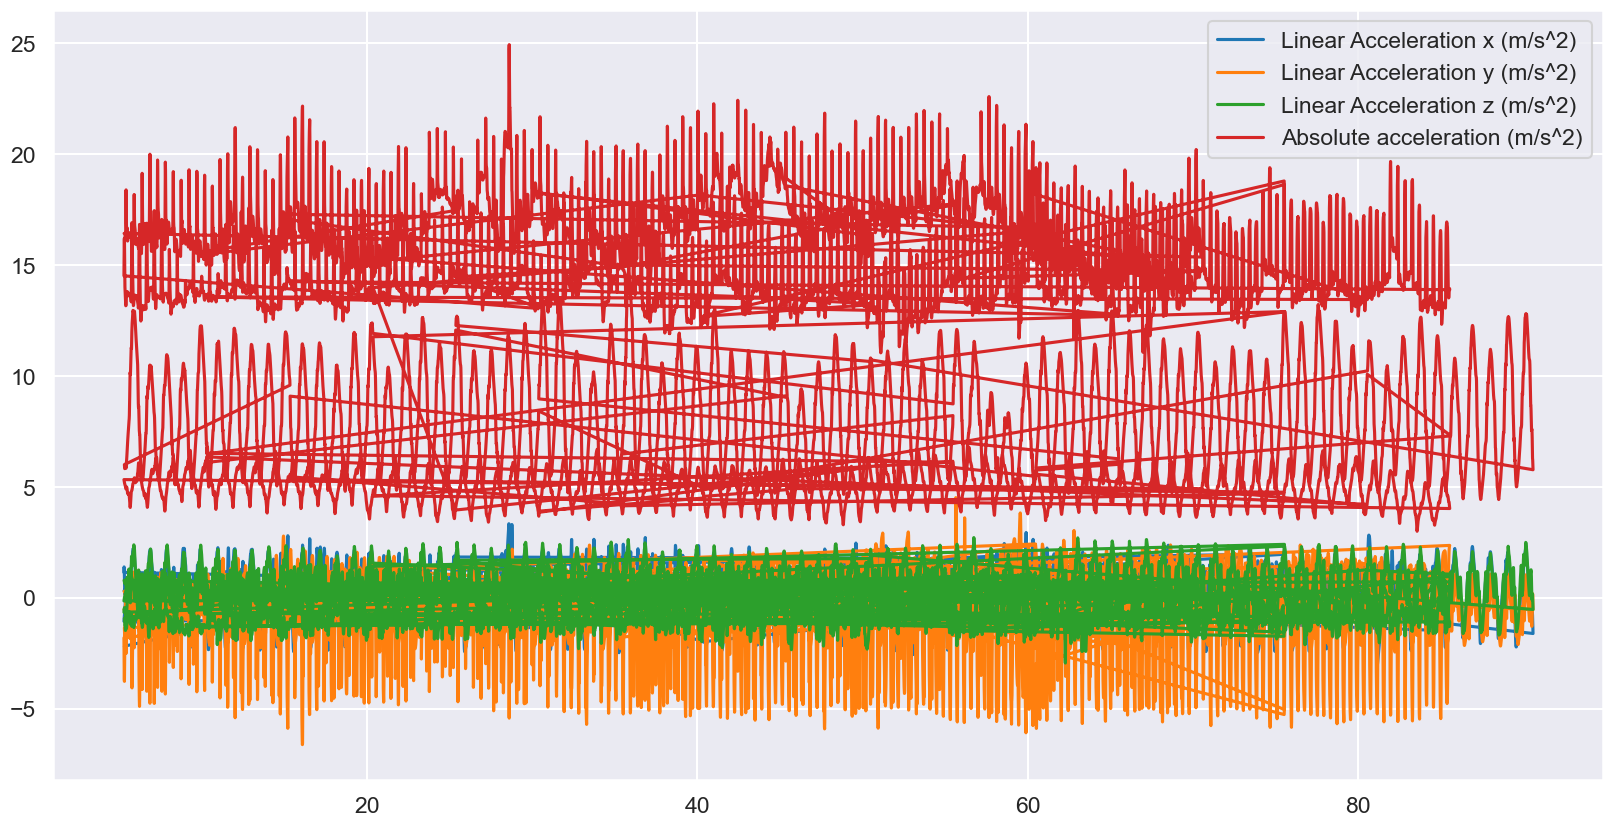

In [349]:
#combine all segments and create plot
all_segments = pd.concat(segmented_data)
segmented_data[0].columns
all_segments.columns
#columns: ['Time (s)', 'Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)',
# 'Absolute acceleration (m/s^2)', 'Activity']
#plot all segments
sns.set_style("darkgrid")
sns.set_context("talk")
plt.figure(figsize=(20, 10))
plt.plot(all_segments["Time (s)"], all_segments["Linear Acceleration x (m/s^2)"], label="Linear Acceleration x (m/s^2)")
plt.plot(all_segments["Time (s)"], all_segments["Linear Acceleration y (m/s^2)"], label="Linear Acceleration y (m/s^2)")
plt.plot(all_segments["Time (s)"], all_segments["Linear Acceleration z (m/s^2)"], label="Linear Acceleration z (m/s^2)")
plt.plot(all_segments["Time (s)"], all_segments["Absolute acceleration (m/s^2)"], label="Absolute acceleration (m/s^2)")
plt.legend()
plt.show()


In [289]:
feature_matrix

array([], dtype=float64)

In [272]:
#segment data in 5 second windows
def segment_data(data, window_size=5, sample_rate=100):
    samples = len(data)
    window_samples = window_size * sample_rate
    segments = []
    for i in range(0, samples, window_samples):
        segment = data[i:i+window_samples]
        if len(segment) == window_samples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments

ajbrp_data = segment_data(ajbrp_data)
ajflp_data = segment_data(ajflp_data)
awbrp_data = segment_data(awbrp_data)
awflp_data = segment_data(awflp_data)

#append data
jumping = ajbrp_data + ajflp_data
walking = awbrp_data + awflp_data
# Prepare your data and labels:
all_data = np.array(jumping + walking)
labels = all_data[:, :, -1].flatten()  # Get labels from the last column

# Remove the 'Activity' column from the data:
data = all_data[:, :, :-1].reshape(all_data.shape[0], -1)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
all_data = np.array(all_data)
all_data = all_data.reshape(data.shape[0], -1)
data = all_data[:, :-1]
labels = all_data[:, -1]
#split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.1, random_state=42)


In [ ]:
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998
0,50.292085,5.419920,-13.031165,0.118472,22.064530,0.0,50.302126,5.088176,-13.151826,0.115353,...,-1.520938,0.196899,1.398811,17.348474,0.0,55.302445,-0.780933,-3.470466,0.807184,20.899437
1,50.289417,1.965360,-1.426192,-2.003690,15.959830,0.0,50.299459,1.419830,-3.063551,-1.889127,...,-0.634404,8.905016,-1.853257,10.674120,0.0,55.300365,-0.782449,9.036503,-1.250889,10.506121
2,10.148662,1.467183,0.663220,3.789529,8.056525,1.0,10.158704,1.037325,1.294654,3.533699,...,0.060530,-3.293320,-1.613979,16.989297,1.0,15.159625,0.559676,-2.751749,-0.682438,16.925461
3,75.393784,-0.199663,1.301337,1.767836,3.910948,1.0,75.403826,-0.098610,1.068359,1.979634,...,0.292997,1.766540,-0.153207,2.355629,1.0,80.404698,0.516248,1.819890,-0.111225,2.461449
4,40.251322,5.988954,-14.148191,2.168945,26.735892,0.0,40.261363,5.605694,-14.645358,1.769883,...,-2.513974,4.591126,1.003961,20.906083,0.0,45.261656,-3.355737,6.087036,0.483712,19.700246


In [ ]:
# define Standard Scaler to normalize inputs
scaler = StandardScaler()

# defining classifier and pupeline
l_reg = LogisticRegression(max_iter=10000)
clf = make_pipeline(StandardScaler(), l_reg)

# train
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
y_clf_prob = clf.predict_proba(X_test)
print("y_pred is: ", y_pred)
print("y_clf_prob is: ", y_clf_prob)

acc = accuracy_score(Y_test, y_pred)
print("Accuracy: ", acc)
      
recall = recall_score(Y_test, y_pred)
print("recall is : ", recall)


y_pred is:  [1. 1. 0. 1. 0. 1. 0.]
y_clf_prob is:  [[8.02185196e-04 9.99197815e-01]
 [3.27888354e-04 9.99672112e-01]
 [9.99720589e-01 2.79411291e-04]
 [3.56713807e-04 9.99643286e-01]
 [9.99823118e-01 1.76881967e-04]
 [3.97724286e-04 9.99602276e-01]
 [9.99714068e-01 2.85931949e-04]]
Accuracy:  1.0
recall is :  1.0


In [ ]:
# # Splitting the data into training data and testing data
# def create_splits(segments, test_size=0.1):
#     train_df, test_df = train_test_split(segments, test_size=test_size, random_state=42)
#     train_df = pd.concat(train_df).reset_index(drop=True)
#     test_df = pd.concat(test_df).reset_index(drop=True)
#     return train_df, test_df

In [ ]:
train_df.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
count,27500.000000,27500.000000,27500.000000,27500.000000,27500.000000,27500.000000
mean,43.581611,0.143203,-0.283336,0.008663,10.681589,0.527273
std,22.961593,2.138415,6.491891,1.777733,6.165506,0.499265
min,5.100502,-6.286511,-18.781762,-5.503200,2.098244,0.000000
25%,23.617971,-1.498423,-3.431269,-1.232544,5.557226,0.000000
50%,43.388693,0.147695,-0.081243,-0.165337,9.484056,1.000000
75%,61.900412,1.588297,2.877428,0.908647,14.827655,1.000000
max,90.472202,8.055139,12.652429,5.996266,34.012068,1.000000


In [ ]:
test_df.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),Activity
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,50.658783,0.179061,-0.348611,0.348581,11.425357,0.571429
std,22.791760,2.304088,6.343563,2.271925,5.662498,0.494942
min,15.169666,-5.184066,-16.501816,-4.084445,2.336708,0.000000
25%,28.974705,-1.749938,-3.766099,-1.411551,7.054108,0.000000
50%,47.776869,0.238936,-0.287632,-0.038365,10.406448,1.000000
75%,71.646701,1.914353,3.214873,1.760335,14.894717,1.000000
max,85.426354,6.657708,12.151955,5.852439,27.817648,1.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [ ]:
    
#extract features from each window
def extract_features(data):
    #mean
    mean = data.mean(axis=1)
    #std
    std = data.std(axis=1)
    #max
    max = data.max(axis=1)
    #min
    min = data.min(axis=1)
    #median
    median = np.median(data, axis=1)
    #range
    range = max - min
    #variance
    variance = np.var(data, axis=1)
    #rms
    rms = np.sqrt(np.mean(data**2, axis=1))
    #skew
    skew = pd.DataFrame(data).skew(axis=1)
    #kurtosis
    kurtosis = pd.DataFrame(data).kurtosis(axis=1)
    